# `l2hmc`-qcd

- For 4D $SU(3)$ @ $\beta = 6.0$, $\langle U_{P}\rangle \approx 0.6$

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'

In [2]:
!unset TF_XLA_FLAGS KMP_SETTINGS KMP_AFFINITY KMP_BLOCKTIME

# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2

# unset verbose TF XLA Flags
!unset TF_XLA_FLAGS
!unset KMP_AFFINITY KMP_SETTINGS

import os
from __future__ import absolute_import, print_function, annotations, division

import hydra
import torch
import tensorflow as tf
#tf.config.run_functions_eagerly(True)
import numpy as np

from l2hmc.main import setup, setup_tensorflow, setup_torch

os.environ['OMP_NUM_THREADS'] = '8'

_ = setup_torch(
    precision='float64',
    seed=1234,
)

_ = setup_tensorflow(
    precision='float64',
)

from hydra.core.global_hydra import GlobalHydra
from l2hmc.utils.rich import print_config

import logging

from rich.logging import RichHandler

log = logging.getLogger('root')
log.setLevel('INFO')
handler = RichHandler(
    show_path=False,
    rich_tracebacks=True
)
log.handlers = [handler]

--------------------------------------------------------------------------

  Local host:   thetagpu24
  Local device: mlx5_0
--------------------------------------------------------------------------
Using: float64 precision


In [5]:
import horovod.tensorflow as hvdtf
import horovod.torch as hvdpt

hvdtf.size()
hvdpt.size()

from __future__ import absolute_import, print_function, annotations, division
import os
import hydra

from typing import Optional
from pathlib import Path

from omegaconf import OmegaConf
from hydra import (
    initialize,
    initialize_config_module,
    initialize_config_dir,
    compose
)

from l2hmc.common import get_timestamp
from l2hmc.configs import CONF_DIR
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment
from l2hmc.experiment.tensorflow.experiment import Experiment as tfExperiment
from hydra.core.global_hydra import GlobalHydra

from l2hmc.utils.rich import print_config

import l2hmc.group.su3.pytorch.group as gpt
import l2hmc.group.su3.tensorflow.group as gtf
from l2hmc.distributions.pytorch.haarSUN import HaarSUN as HaarSUNpt
hSU3 = HaarSUNpt(3)

ptsu3 = gpt.SU3()
tfsu3 = gtf.SU3()

import l2hmc
l2hmc.__file__

'/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/__init__.py'

## Specify `overrides` for creating Experiment

In [6]:
GlobalHydra.instance().clear()

defaults = [
    'steps.nera=8',
    'steps.nepoch=500',
    'steps.test=2000',
    'steps.print=100',
    'steps.log=10',
]

defaults_u1 = [
    *defaults,
    'dynamics.nchains=1024',
    'dynamics.nleapfrog=5',
    'dynamics.latvolume=[8, 8]',
    'network.units=[16, 16, 16, 16]',
    'annealing_schedule.beta_init=1.0',
    'annealing_schedule.beta_final=4.0',
]

defaults_su3 = [
    *defaults,
    'dynamics=su3',
    'dynamics.verbose=true',
    'dynamics.nchains=5',
    'steps.nera=0',
    'steps.nepoch=0',
    'steps.test=250',
    'dynamics.nleapfrog=8',
    'network.units=[1]',
    'dynamics.latvolume=[8, 8, 8, 16]',
    'annealing_schedule.beta_init=6.0',
    'annealing_schedule.beta_final=6.0',
]

In [7]:
import gc
import GPUtil

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
    
torch.clear_autocast_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  1% |
|  6 |  0% |  0% |
|  7 |  0% | 10% |


# Build `Experiment` objects

We can use the helper function `l2hmc.configs.get_experiment`,
which takes as input:

- `overrides (list[str])`: A list of strings of the form `'key=val'`, specifying which options from our `l2hmc.configs.ExperimentConfig` we wish to override

- `build_networks (Optional[bool])`: Whether or not to build NNs inside `Dynamics` object.

## TensorFlow

In [8]:
from l2hmc.configs import get_experiment
GlobalHydra.instance().clear()
tfExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=tensorflow',
        'init_wandb=False',
        'init_aim=False',
    ],
    build_networks=True,
)

12:20:49 DEBUG    Setting JobRuntime:name=UNKNOWN_NAME                                                      ]8;id=462141;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=7855;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

         DEBUG    Setting JobRuntime:name=app                                                               ]8;id=95046;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=955227;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\


## PyTorch

In [9]:
ptExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=pytorch',
        'init_wandb=False',
        'init_aim=False',
    ],
    build_networks=True,
)

12:20:52 DEBUG    Setting JobRuntime:name=app                                                               ]8;id=988319;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=984894;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

12:20:54 DEBUG    Built networks.                                                                        ]8;id=610509;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py\dynamics.py]8;;\:]8;id=704185;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py#145\145]8;;\

         DEBUG    dynamics._networks_built: True                                                         ]8;id=726754;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py\dynamics.py]8;;\:]8;id=103202;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py#155\155]8;;\

#  Run HMC

## TensorFlow

12:22:34 WARNING  Step size `eps` not specified for HMC! Using default: 0.125                             ]8;id=78980;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=225542;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#501\501]8;;\

         WARNING  x.shape (original): (5, 4, 8, 8, 8, 16, 3, 3)                                           ]8;id=151252;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=982837;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#514\514]8;;\

         WARNING  x[:nchains].shape: (5, 4, 8, 8, 8, 16, 3, 3)                                            ]8;id=363049;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=116275;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#520\520]8;;\

12:22:36 INFO     energy=-271.48, logprob=-271.48, logdet=0.00, acc=1.00, sumlogdet=0.00+0.00j,           ]8;id=555413;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=703072;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=1.00, plaqs=0.00, sinQ=0.00, intQ=0.01, dQint=0.66, dQsin=0.00, loss=97.55,                  
                  step=0.00, beta=6.00, dt=1.82, eps=0.03, hmc_step=0.00                                                

12:22:44 INFO     energy=-133238.90, logprob=-133238.90, logdet=0.00, acc=1.00, sumlogdet=0.00+0.00j,     ]8;id=320227;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=476202;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=1.00, plaqs=0.45, sinQ=-0.00, intQ=-0.05, dQint=0.28, dQsin=0.00, loss=99.56,                
                  step=5.00, beta=6.00, dt=1.72, eps=0.05, hmc_step=5.00                                                

12:22:53 INFO     energy=-154848.32, logprob=-154848.32, logdet=0.00, acc=1.00, sumlogdet=0.00+0.00j,     ]8;id=41512;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=436470;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=1.00, plaqs=0.53, sinQ=-0.00, intQ=-0.03, dQint=0.26, dQsin=0.00, loss=99.67,                
                  step=10.00, beta=6.00, dt=1.73, eps=0.08, hmc_step=10.00                                              

12:23:02 INFO     energy=-162775.82, logprob=-162775.82, logdet=0.00, acc=0.61, sumlogdet=0.00+0.00j,     ]8;id=290228;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=694562;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.55, sinQ=-0.00, intQ=-0.02, dQint=0.05, dQsin=0.00, loss=99.96,                
                  step=15.00, beta=6.00, dt=1.74, eps=0.11, hmc_step=15.00                                              

12:23:11 INFO     energy=-165924.08, logprob=-165924.08, logdet=0.00, acc=0.80, sumlogdet=0.00+0.00j,     ]8;id=845689;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=42157;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.80, plaqs=0.56, sinQ=-0.00, intQ=-0.02, dQint=0.15, dQsin=0.00, loss=99.83,                
                  step=20.00, beta=6.00, dt=1.89, eps=0.09, hmc_step=20.00                                              

12:23:19 INFO     energy=-168721.92, logprob=-168721.92, logdet=0.00, acc=0.60, sumlogdet=0.00+0.00j,     ]8;id=185957;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=284867;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.57, sinQ=0.00, intQ=0.07, dQint=0.04, dQsin=0.00, loss=99.98,                  
                  step=25.00, beta=6.00, dt=1.73, eps=0.08, hmc_step=25.00                                              

12:23:28 INFO     energy=-170518.05, logprob=-170518.05, logdet=0.00, acc=0.43, sumlogdet=0.00+0.00j,     ]8;id=162078;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=314858;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.20, plaqs=0.58, sinQ=-0.00, intQ=-0.04, dQint=0.02, dQsin=0.00, loss=99.97,                
                  step=30.00, beta=6.00, dt=1.73, eps=0.07, hmc_step=30.00                                              

12:23:37 INFO     energy=-172334.70, logprob=-172334.70, logdet=0.00, acc=0.60, sumlogdet=0.00+0.00j,     ]8;id=888762;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=162058;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.01, dQint=0.09, dQsin=0.00, loss=99.93,                  
                  step=35.00, beta=6.00, dt=1.73, eps=0.05, hmc_step=35.00                                              

12:23:45 INFO     energy=-173005.75, logprob=-173005.75, logdet=0.00, acc=0.65, sumlogdet=0.00+0.00j,     ]8;id=817019;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=874396;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.05, dQint=0.11, dQsin=0.00, loss=99.86,                  
                  step=40.00, beta=6.00, dt=1.74, eps=0.05, hmc_step=40.00                                              

12:23:54 INFO     energy=-173797.83, logprob=-173797.83, logdet=0.00, acc=0.80, sumlogdet=0.00+0.00j,     ]8;id=487065;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=43057;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.80, plaqs=0.59, sinQ=-0.00, intQ=-0.06, dQint=0.10, dQsin=0.00, loss=99.85,                
                  step=45.00, beta=6.00, dt=1.74, eps=0.03, hmc_step=45.00                                              

12:24:03 INFO     energy=-173610.62, logprob=-173610.62, logdet=0.00, acc=0.69, sumlogdet=0.00+0.00j,     ]8;id=590459;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=404942;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.05, dQint=0.09, dQsin=0.00, loss=99.91,                
                  step=50.00, beta=6.00, dt=1.73, eps=0.03, hmc_step=50.00                                              

12:24:11 INFO     energy=-174071.63, logprob=-174071.63, logdet=0.00, acc=0.61, sumlogdet=0.00+0.00j,     ]8;id=801383;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=366574;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.02, dQint=0.17, dQsin=0.00, loss=99.87,                  
                  step=55.00, beta=6.00, dt=1.72, eps=0.03, hmc_step=55.00                                              

12:24:20 INFO     energy=-173986.96, logprob=-173986.96, logdet=0.00, acc=0.57, sumlogdet=0.00+0.00j,     ]8;id=519943;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=358306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.06, dQint=0.11, dQsin=0.00, loss=99.93,                  
                  step=60.00, beta=6.00, dt=1.74, eps=0.03, hmc_step=60.00                                              

12:24:29 INFO     energy=-173918.98, logprob=-173918.98, logdet=0.00, acc=0.60, sumlogdet=0.00+0.00j,     ]8;id=611173;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=856123;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.06, dQint=0.16, dQsin=0.00, loss=99.85,                  
                  step=65.00, beta=6.00, dt=1.75, eps=0.02, hmc_step=65.00                                              

12:24:38 INFO     energy=-174547.99, logprob=-174547.99, logdet=0.00, acc=0.77, sumlogdet=0.00+0.00j,     ]8;id=490858;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=499053;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.06, dQint=0.08, dQsin=0.00, loss=99.84,                
                  step=70.00, beta=6.00, dt=1.72, eps=0.02, hmc_step=70.00                                              

12:24:46 INFO     energy=-174601.40, logprob=-174601.40, logdet=0.00, acc=0.69, sumlogdet=0.00+0.00j,     ]8;id=47531;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=820919;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.80, plaqs=0.59, sinQ=-0.00, intQ=-0.06, dQint=0.15, dQsin=0.00, loss=99.80,                
                  step=75.00, beta=6.00, dt=1.75, eps=0.02, hmc_step=75.00                                              

12:24:55 INFO     energy=-174102.12, logprob=-174102.12, logdet=0.00, acc=0.65, sumlogdet=0.00+0.00j,     ]8;id=978278;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=493711;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.11, dQint=0.08, dQsin=0.00, loss=99.92,                  
                  step=80.00, beta=6.00, dt=1.74, eps=0.03, hmc_step=80.00                                              

12:25:04 INFO     energy=-174098.71, logprob=-174098.71, logdet=0.00, acc=0.50, sumlogdet=0.00+0.00j,     ]8;id=912458;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=857047;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.06, dQint=0.10, dQsin=0.00, loss=99.91,                
                  step=85.00, beta=6.00, dt=1.73, eps=0.03, hmc_step=85.00                                              

12:25:13 INFO     energy=-174585.37, logprob=-174585.37, logdet=0.00, acc=0.80, sumlogdet=0.00+0.00j,     ]8;id=623814;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=924390;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.01, dQint=0.10, dQsin=0.00, loss=99.90,                  
                  step=90.00, beta=6.00, dt=1.73, eps=0.02, hmc_step=90.00                                              

12:25:21 INFO     energy=-174323.62, logprob=-174323.62, logdet=0.00, acc=0.83, sumlogdet=0.00+0.00j,     ]8;id=178227;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=460950;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#640\640]8;;\
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.05, dQint=0.05, dQsin=0.00, loss=99.97,                  
                  step=95.00, beta=6.00, dt=1.75, eps=0.02, hmc_step=95.00                                              

12:25:30 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=819004;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=854318;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#889\889]8;;\
                  /outputs/2022-08-24-122049/tensorflow/hmc/plots/ridgeplots/energy_ridgeplot.svg                       

12:25:32 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=459142;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=310041;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#889\889]8;;\
                  /outputs/2022-08-24-122049/tensorflow/hmc/plots/ridgeplots/logprob_ridgeplot.svg                      

12:25:35 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=288401;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=129894;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#889\889]8;;\
                  /outputs/2022-08-24-122049/tensorflow/hmc/plots/ridgeplots/logdet_ridgeplot.svg                       

12:25:42 INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks/outp ]8;id=194638;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=457241;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#208\208]8;;\
                  uts/2022-08-24-122049/tensorflow/hmc/data/hmc_data.h5                                                 

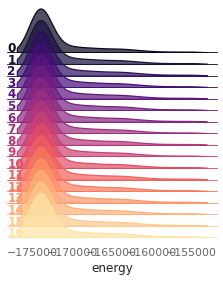

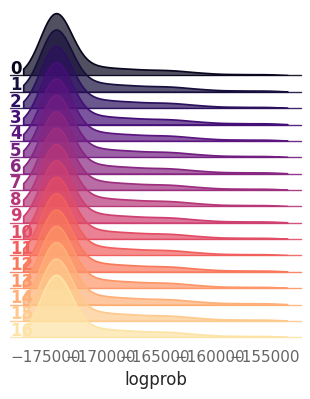

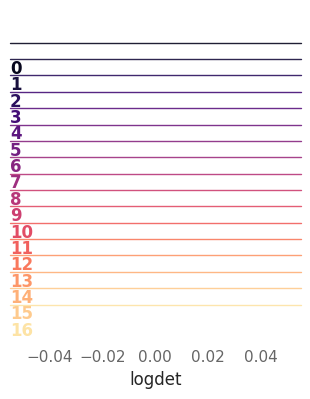

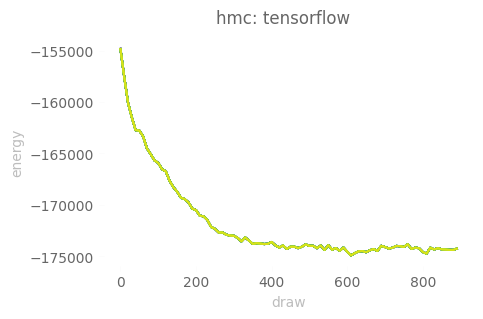

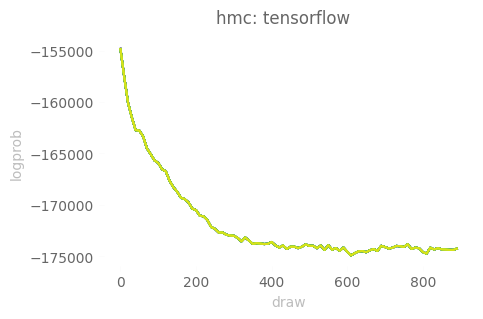

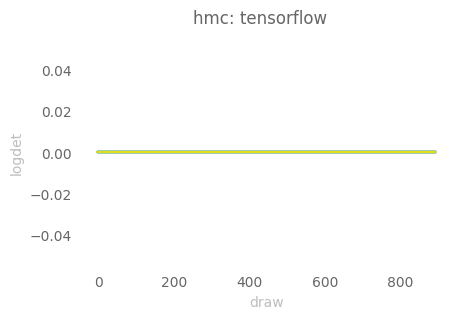

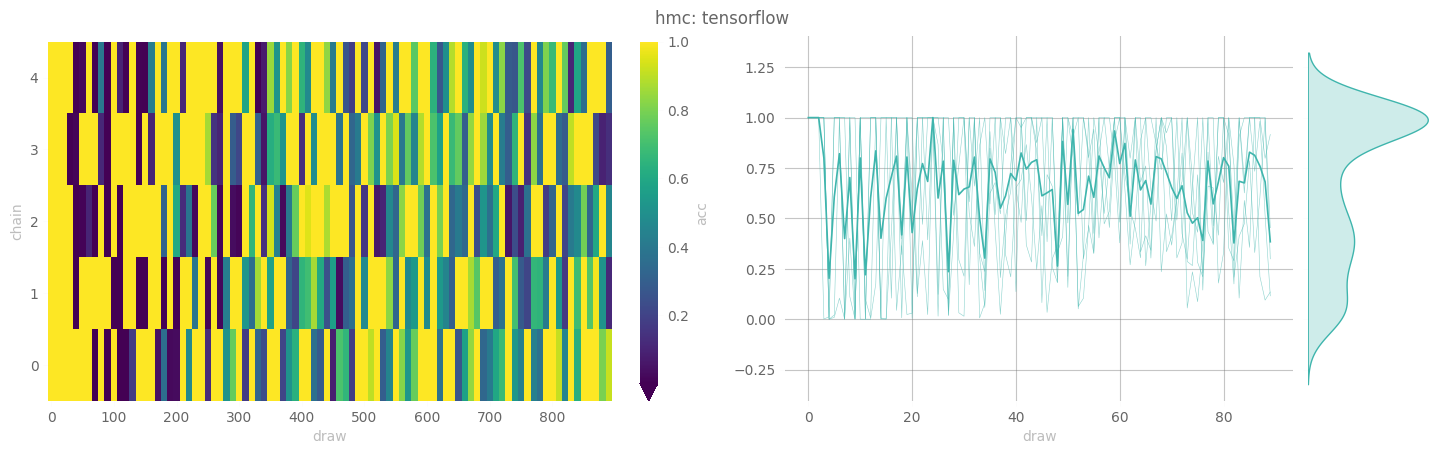

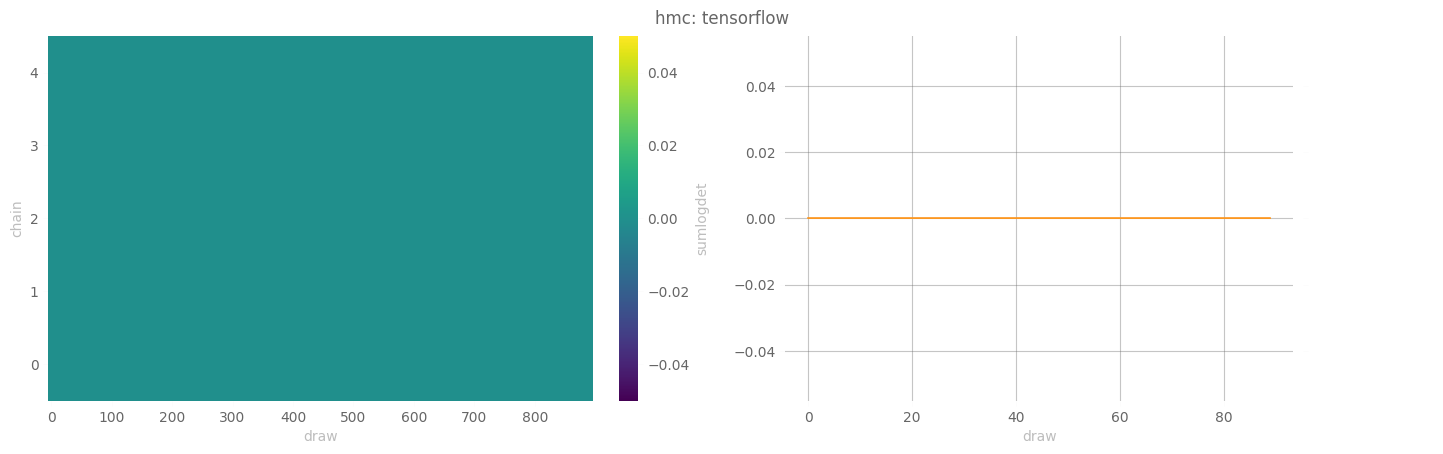

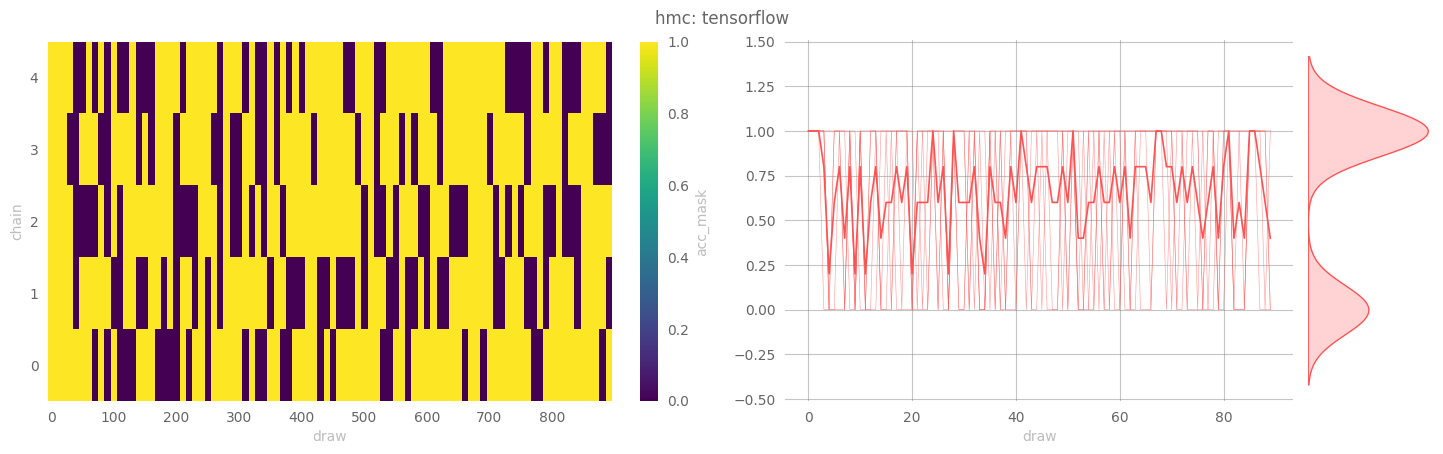

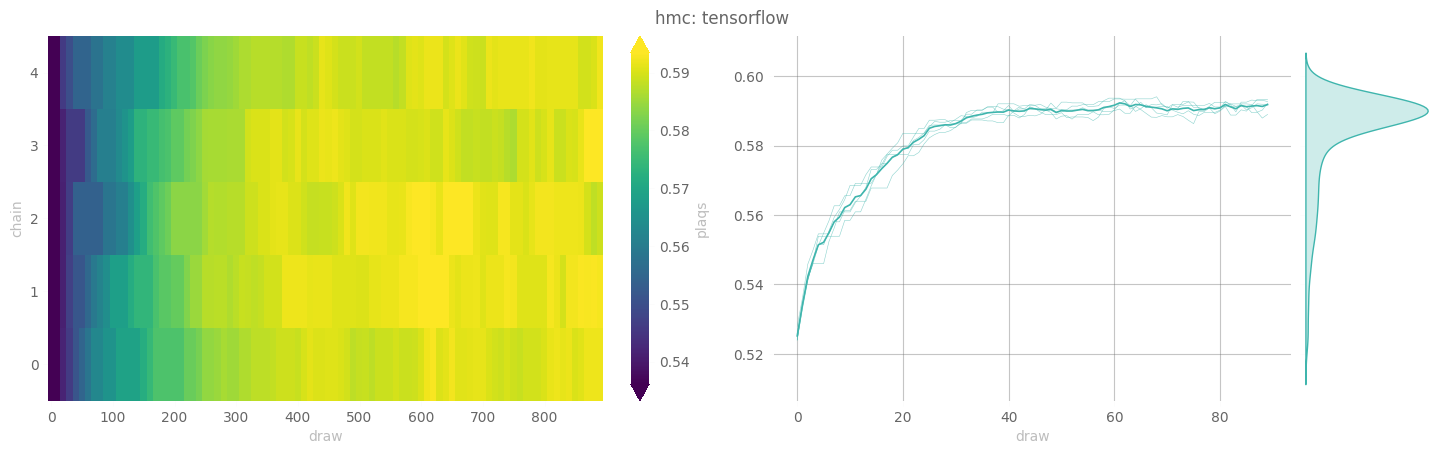

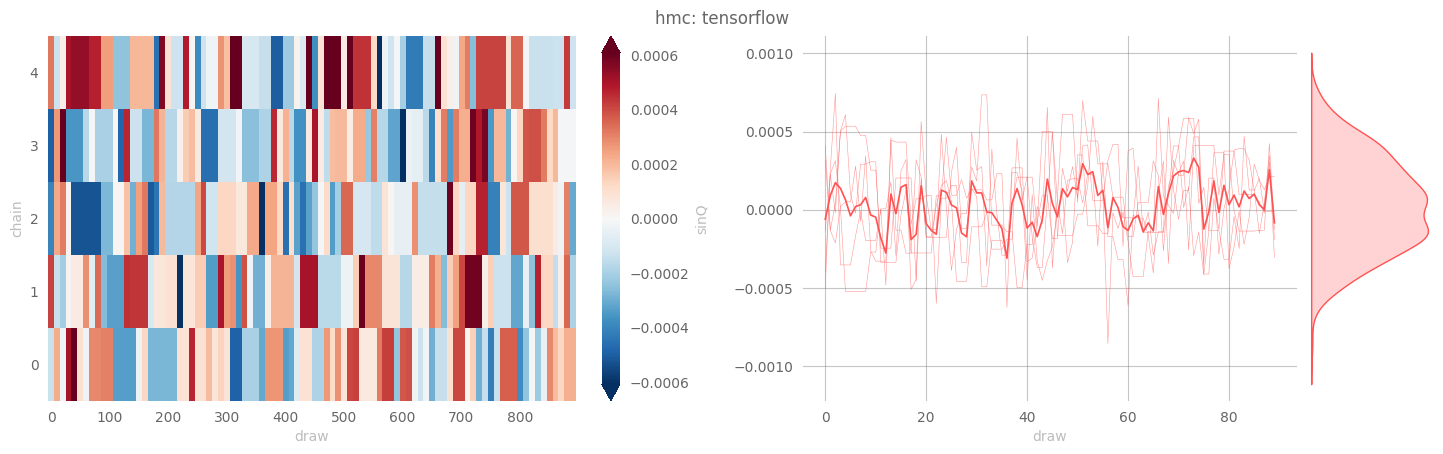

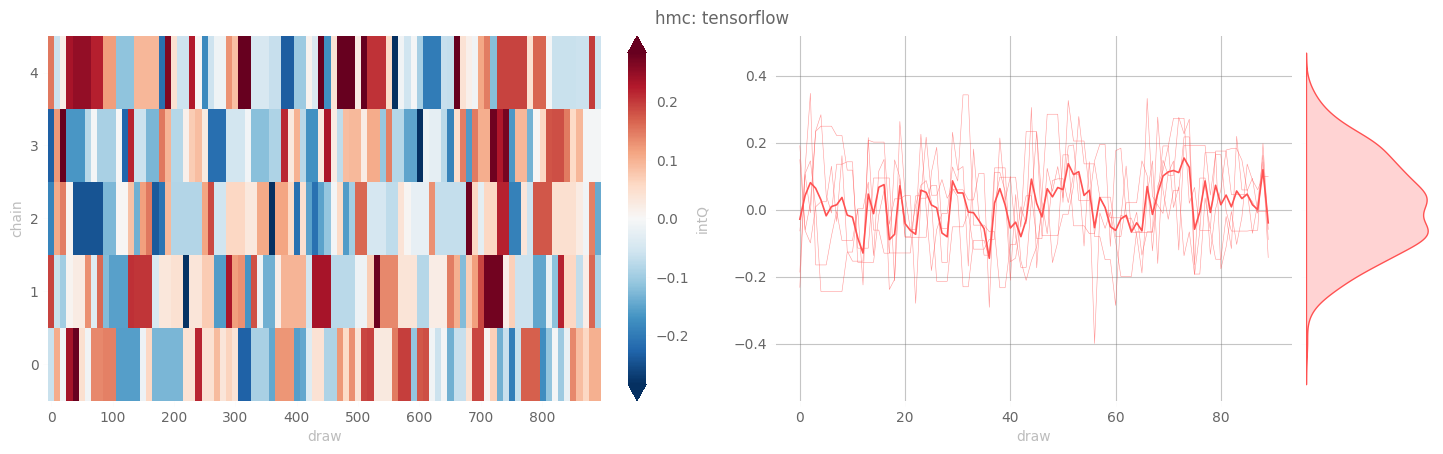

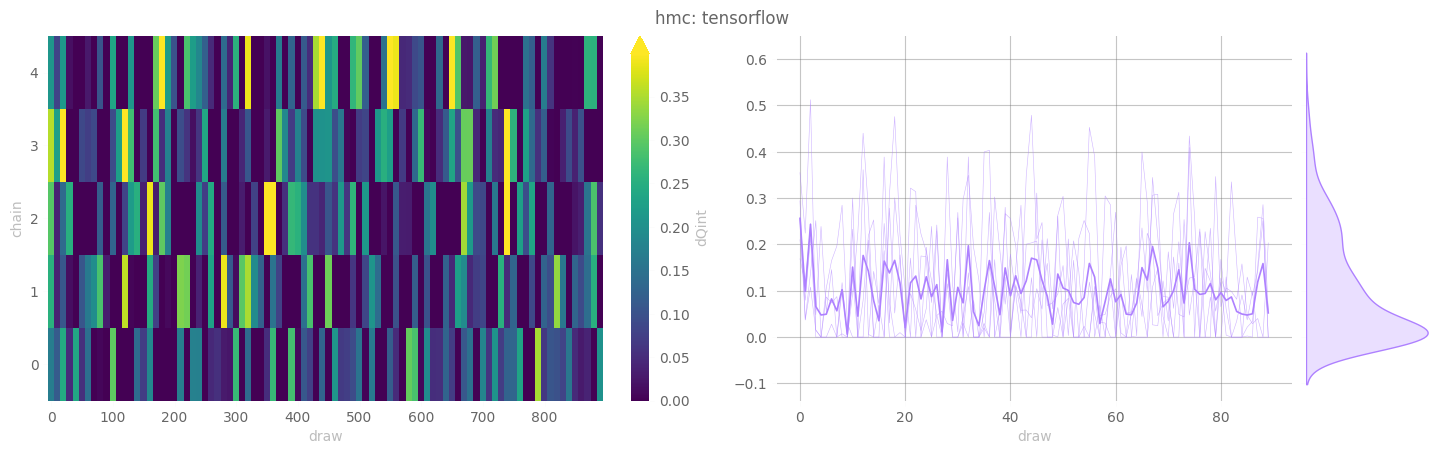

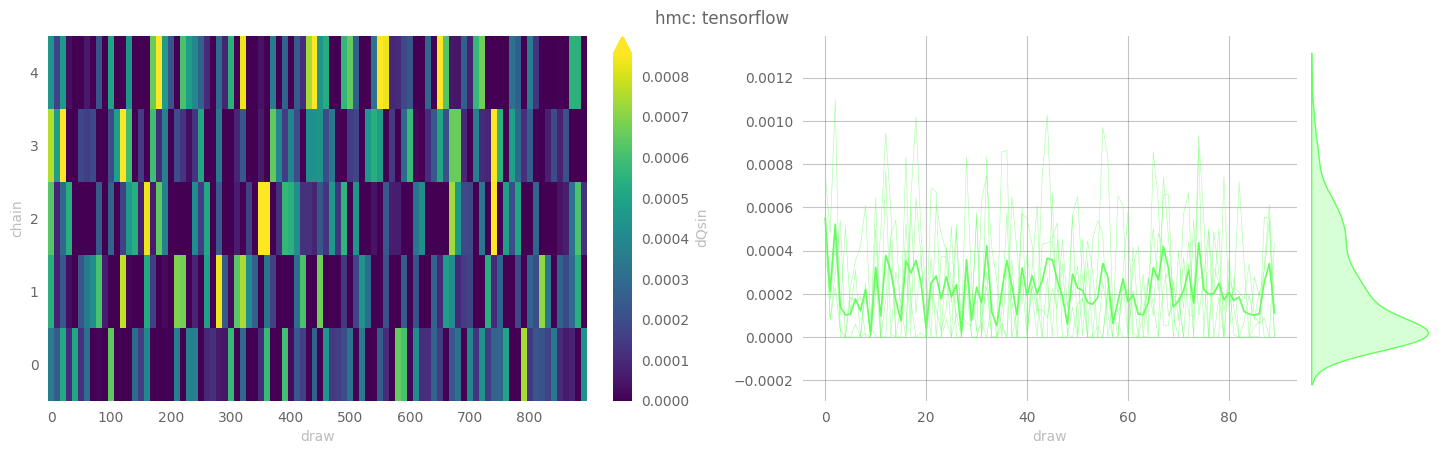

In [12]:
outputs_tf = tfExpSU3.evaluate(
    beta=0.7796,
    eps=0.03125,
    nleapfrog=16,
    eval_steps=100,
    job_type='hmc'
)

## PyTorch:

12:26:48 WARNING  Using step size eps: 0.1250 for generic HMC                                             ]8;id=688276;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=672182;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#595\595]8;;\

         WARNING  x.shape (original): torch.Size([5, 4, 8, 8, 8, 16, 3, 3])                               ]8;id=200711;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=113411;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#178\178]8;;\

         WARNING  x[:nchains].shape: torch.Size([5, 4, 8, 8, 8, 16, 3, 3])                                ]8;id=736791;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=734143;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#178\178]8;;\

12:26:49 INFO     energy=97.50, logprob=97.50, logdet=0.00, acc=1.00, sumlogdet=0.00, acc_mask=1.00,      ]8;id=849284;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=608608;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  plaqs=0.00, sinQ=-0.00, intQ=-0.04, dQint=0.37, dQsin=0.00, loss=99.23, step=0.00,                    
                  beta=0.78, dt=1.18, eps=0.03, hmc_step=0.00                                                           

12:26:52 INFO     energy=-1559.30, logprob=-1559.30, logdet=0.00, acc=0.99, sumlogdet=0.00,               ]8;id=952097;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=988809;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.04, sinQ=0.00, intQ=0.04, dQint=0.23, dQsin=0.00, loss=99.68,                  
                  step=2.00, beta=0.78, dt=1.14, eps=0.04, hmc_step=2.00                                                

12:26:54 INFO     energy=-1993.18, logprob=-1993.18, logdet=0.00, acc=0.97, sumlogdet=0.00,               ]8;id=282413;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=162368;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=0.00, intQ=0.06, dQint=0.55, dQsin=0.00, loss=98.32,                  
                  step=4.00, beta=0.78, dt=1.16, eps=0.05, hmc_step=4.00                                                

12:26:56 INFO     energy=-1993.41, logprob=-1993.41, logdet=0.00, acc=0.90, sumlogdet=0.00,               ]8;id=889115;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=881306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.16, dQint=0.73, dQsin=0.00, loss=95.15,                  
                  step=6.00, beta=0.78, dt=1.19, eps=0.06, hmc_step=6.00                                                

12:26:59 INFO     energy=-1935.93, logprob=-1935.93, logdet=0.00, acc=0.85, sumlogdet=0.00,               ]8;id=755108;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=339203;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=-0.00, intQ=-0.13, dQint=0.70, dQsin=0.00, loss=97.55,                
                  step=8.00, beta=0.78, dt=1.70, eps=0.07, hmc_step=8.00                                                

12:27:06 INFO     energy=-1826.76, logprob=-1826.76, logdet=0.00, acc=0.60, sumlogdet=0.00,               ]8;id=832110;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=825218;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=0.00, intQ=0.05, dQint=0.14, dQsin=0.00, loss=98.98,                  
                  step=10.00, beta=0.78, dt=3.87, eps=0.08, hmc_step=10.00                                              

12:27:12 INFO     energy=-1576.91, logprob=-1576.91, logdet=0.00, acc=0.84, sumlogdet=0.00,               ]8;id=468368;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=755692;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=-0.00, intQ=-0.33, dQint=0.68, dQsin=0.00, loss=98.01,                
                  step=12.00, beta=0.78, dt=3.92, eps=0.08, hmc_step=12.00                                              

12:27:26 INFO     energy=-1817.87, logprob=-1817.87, logdet=0.00, acc=0.76, sumlogdet=0.00,               ]8;id=74211;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=82304;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.04, dQint=0.25, dQsin=0.00, loss=99.61,                  
                  step=14.00, beta=0.78, dt=7.83, eps=0.10, hmc_step=14.00                                              

12:27:48 INFO     energy=-1551.09, logprob=-1551.09, logdet=0.00, acc=0.89, sumlogdet=0.00,               ]8;id=414442;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=224552;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.01, dQint=0.34, dQsin=0.00, loss=99.17,                  
                  step=16.00, beta=0.78, dt=12.23, eps=0.12, hmc_step=16.00                                             

12:28:14 INFO     energy=-1789.98, logprob=-1789.98, logdet=0.00, acc=0.79, sumlogdet=0.00,               ]8;id=50054;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=937984;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=0.00, intQ=0.20, dQint=0.19, dQsin=0.00, loss=98.75,                  
                  step=18.00, beta=0.78, dt=11.97, eps=0.12, hmc_step=18.00                                             

12:28:31 INFO     energy=-1678.90, logprob=-1678.90, logdet=0.00, acc=0.76, sumlogdet=0.00,               ]8;id=300032;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=842428;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.07, dQint=0.69, dQsin=0.00, loss=97.57,                  
                  step=20.00, beta=0.78, dt=7.32, eps=0.09, hmc_step=20.00                                              

12:28:48 INFO     energy=-1594.97, logprob=-1594.97, logdet=0.00, acc=0.89, sumlogdet=0.00,               ]8;id=39840;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=230048;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=-0.00, intQ=-0.12, dQint=0.35, dQsin=0.00, loss=99.29,                
                  step=22.00, beta=0.78, dt=6.81, eps=0.09, hmc_step=22.00                                              

12:29:03 INFO     energy=-1669.74, logprob=-1669.74, logdet=0.00, acc=0.57, sumlogdet=0.00,               ]8;id=531329;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=869921;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=-0.00, intQ=-0.34, dQint=0.56, dQsin=0.00, loss=98.10,                
                  step=24.00, beta=0.78, dt=6.54, eps=0.09, hmc_step=24.00                                              

12:29:14 INFO     energy=-1779.66, logprob=-1779.66, logdet=0.00, acc=0.77, sumlogdet=0.00,               ]8;id=91926;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=831306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=0.00, intQ=0.26, dQint=0.89, dQsin=0.00, loss=97.30,                  
                  step=26.00, beta=0.78, dt=6.53, eps=0.09, hmc_step=26.00                                              

12:29:38 INFO     energy=-1715.81, logprob=-1715.81, logdet=0.00, acc=0.66, sumlogdet=0.00,               ]8;id=978138;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=984580;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.06, dQint=0.45, dQsin=0.00, loss=98.98,                  
                  step=28.00, beta=0.78, dt=10.92, eps=0.11, hmc_step=28.00                                             

12:30:28 INFO     energy=-1865.94, logprob=-1865.94, logdet=0.00, acc=0.68, sumlogdet=0.00,               ]8;id=733360;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=332383;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=0.00, intQ=0.27, dQint=0.16, dQsin=0.00, loss=99.38,                  
                  step=30.00, beta=0.78, dt=10.63, eps=0.11, hmc_step=30.00                                             

12:30:42 INFO     energy=-1651.23, logprob=-1651.23, logdet=0.00, acc=0.79, sumlogdet=0.00,               ]8;id=320470;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=990957;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.28, dQint=0.85, dQsin=0.00, loss=95.85,                  
                  step=32.00, beta=0.78, dt=5.65, eps=0.09, hmc_step=32.00                                              

12:31:27 INFO     energy=-1824.98, logprob=-1824.98, logdet=0.00, acc=0.50, sumlogdet=0.00,               ]8;id=483219;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=69444;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=0.00, intQ=0.68, dQint=0.29, dQsin=0.00, loss=98.08,                  
                  step=34.00, beta=0.78, dt=10.30, eps=0.11, hmc_step=34.00                                             

12:31:53 INFO     energy=-1920.95, logprob=-1920.95, logdet=0.00, acc=0.68, sumlogdet=0.00,               ]8;id=613395;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=269933;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=0.00, intQ=0.03, dQint=0.16, dQsin=0.00, loss=99.74,                  
                  step=36.00, beta=0.78, dt=5.54, eps=0.09, hmc_step=36.00                                              

12:31:59 INFO     energy=-1775.89, logprob=-1775.89, logdet=0.00, acc=0.71, sumlogdet=0.00,               ]8;id=898112;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=76545;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.08, dQint=0.54, dQsin=0.00, loss=98.36,                  
                  step=38.00, beta=0.78, dt=2.10, eps=0.07, hmc_step=38.00                                              

12:32:07 INFO     energy=-1909.29, logprob=-1909.29, logdet=0.00, acc=0.60, sumlogdet=0.00,               ]8;id=722293;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=447012;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=0.00, intQ=0.21, dQint=0.10, dQsin=0.00, loss=99.62,                  
                  step=40.00, beta=0.78, dt=4.90, eps=0.09, hmc_step=40.00                                              

12:32:15 INFO     energy=-1790.87, logprob=-1790.87, logdet=0.00, acc=0.62, sumlogdet=0.00,               ]8;id=995628;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=211704;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=-0.00, intQ=-0.04, dQint=0.50, dQsin=0.00, loss=98.39,                
                  step=42.00, beta=0.78, dt=4.71, eps=0.08, hmc_step=42.00                                              

12:32:22 INFO     energy=-1582.68, logprob=-1582.68, logdet=0.00, acc=0.75, sumlogdet=0.00,               ]8;id=106213;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=415914;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=0.00, intQ=0.05, dQint=0.30, dQsin=0.00, loss=98.06,                  
                  step=44.00, beta=0.78, dt=4.51, eps=0.08, hmc_step=44.00                                              

12:32:29 INFO     energy=-1574.64, logprob=-1574.64, logdet=0.00, acc=0.74, sumlogdet=0.00,               ]8;id=204055;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=739099;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=-0.00, intQ=-0.08, dQint=0.26, dQsin=0.00, loss=99.01,                
                  step=46.00, beta=0.78, dt=4.32, eps=0.08, hmc_step=46.00                                              

12:32:36 INFO     energy=-1709.19, logprob=-1709.19, logdet=0.00, acc=0.82, sumlogdet=0.00,               ]8;id=929506;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=930457;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=0.00, intQ=0.18, dQint=0.68, dQsin=0.00, loss=98.16,                  
                  step=48.00, beta=0.78, dt=4.17, eps=0.08, hmc_step=48.00                                              

12:32:51 INFO     energy=-1777.01, logprob=-1777.01, logdet=0.00, acc=0.82, sumlogdet=0.00,               ]8;id=481894;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=524830;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=-0.00, intQ=-0.34, dQint=0.77, dQsin=0.00, loss=97.96,                
                  step=50.00, beta=0.78, dt=8.46, eps=0.10, hmc_step=50.00                                              

12:33:10 INFO     energy=-1875.62, logprob=-1875.62, logdet=0.00, acc=0.69, sumlogdet=0.00,               ]8;id=247807;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=858292;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.05, dQint=0.39, dQsin=0.00, loss=98.98,                  
                  step=52.00, beta=0.78, dt=8.21, eps=0.10, hmc_step=52.00                                              

12:33:34 INFO     energy=-1938.64, logprob=-1938.64, logdet=0.00, acc=0.41, sumlogdet=0.00,               ]8;id=836294;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=378802;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.20, plaqs=0.05, sinQ=-0.00, intQ=-0.06, dQint=0.16, dQsin=0.00, loss=99.38,                
                  step=54.00, beta=0.78, dt=12.91, eps=0.12, hmc_step=54.00                                             

12:33:57 INFO     energy=-1759.41, logprob=-1759.41, logdet=0.00, acc=0.45, sumlogdet=0.00,               ]8;id=976250;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=900397;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.01, dQint=0.46, dQsin=0.00, loss=98.45,                  
                  step=56.00, beta=0.78, dt=12.63, eps=0.12, hmc_step=56.00                                             

12:34:23 INFO     energy=-1784.65, logprob=-1784.65, logdet=0.00, acc=0.80, sumlogdet=0.00,               ]8;id=215042;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=540052;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.28, dQint=0.44, dQsin=0.00, loss=98.33,                  
                  step=58.00, beta=0.78, dt=12.27, eps=0.12, hmc_step=58.00                                             

12:34:49 INFO     energy=-1863.02, logprob=-1863.02, logdet=0.00, acc=0.97, sumlogdet=0.00,               ]8;id=932891;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=736536;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=-0.00, intQ=-0.16, dQint=0.54, dQsin=0.00, loss=98.44,                
                  step=60.00, beta=0.78, dt=12.09, eps=0.12, hmc_step=60.00                                             

12:35:19 INFO     energy=-1489.16, logprob=-1489.16, logdet=0.00, acc=0.58, sumlogdet=0.00,               ]8;id=441632;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=183175;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=-0.00, intQ=-0.24, dQint=0.33, dQsin=0.00, loss=98.48,                
                  step=62.00, beta=0.78, dt=15.47, eps=0.14, hmc_step=62.00                                             

12:35:45 INFO     energy=-1690.60, logprob=-1690.60, logdet=0.00, acc=0.45, sumlogdet=0.00,               ]8;id=998815;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=612905;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=0.00, intQ=0.14, dQint=0.22, dQsin=0.00, loss=99.82,                  
                  step=64.00, beta=0.78, dt=11.64, eps=0.11, hmc_step=64.00                                             

12:36:01 INFO     energy=-1815.60, logprob=-1815.60, logdet=0.00, acc=0.65, sumlogdet=0.00,               ]8;id=213133;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=316436;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.04, dQint=0.44, dQsin=0.00, loss=98.53,                  
                  step=66.00, beta=0.78, dt=6.72, eps=0.09, hmc_step=66.00                                              

12:36:21 INFO     energy=-1875.48, logprob=-1875.48, logdet=0.00, acc=0.55, sumlogdet=0.00,               ]8;id=63240;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=852336;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=-0.00, intQ=-0.27, dQint=0.22, dQsin=0.00, loss=99.28,                
                  step=68.00, beta=0.78, dt=11.37, eps=0.11, hmc_step=68.00                                             

12:36:36 INFO     energy=-1662.84, logprob=-1662.84, logdet=0.00, acc=0.81, sumlogdet=0.00,               ]8;id=369608;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=560296;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.22, dQint=0.48, dQsin=0.00, loss=97.68,                  
                  step=70.00, beta=0.78, dt=6.00, eps=0.09, hmc_step=70.00                                              

12:36:55 INFO     energy=-1481.84, logprob=-1481.84, logdet=0.00, acc=0.46, sumlogdet=0.00,               ]8;id=160495;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=523855;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=0.00, intQ=0.30, dQint=0.45, dQsin=0.00, loss=97.09,                  
                  step=72.00, beta=0.78, dt=10.94, eps=0.11, hmc_step=72.00                                             

12:37:09 INFO     energy=-1526.67, logprob=-1526.67, logdet=0.00, acc=0.65, sumlogdet=0.00,               ]8;id=950492;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=810890;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=-0.00, intQ=-0.06, dQint=0.43, dQsin=0.00, loss=97.27,                
                  step=74.00, beta=0.78, dt=5.57, eps=0.09, hmc_step=74.00                                              

12:37:18 INFO     energy=-1910.79, logprob=-1910.79, logdet=0.00, acc=0.73, sumlogdet=0.00,               ]8;id=997075;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=575700;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.21, dQint=0.42, dQsin=0.00, loss=99.00,                  
                  step=76.00, beta=0.78, dt=5.28, eps=0.09, hmc_step=76.00                                              

12:37:31 INFO     energy=-1603.88, logprob=-1603.88, logdet=0.00, acc=0.85, sumlogdet=0.00,               ]8;id=495385;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=349970;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.13, dQint=0.33, dQsin=0.00, loss=99.30,                  
                  step=78.00, beta=0.78, dt=5.13, eps=0.09, hmc_step=78.00                                              

12:37:48 INFO     energy=-1852.25, logprob=-1852.25, logdet=0.00, acc=0.61, sumlogdet=0.00,               ]8;id=145467;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=137293;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=0.00, intQ=0.06, dQint=0.37, dQsin=0.00, loss=99.10,                  
                  step=80.00, beta=0.78, dt=9.92, eps=0.10, hmc_step=80.00                                              

12:38:00 INFO     energy=-1756.70, logprob=-1756.70, logdet=0.00, acc=0.77, sumlogdet=0.00,               ]8;id=50407;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=654841;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=0.00, intQ=0.15, dQint=0.23, dQsin=0.00, loss=99.05,                  
                  step=82.00, beta=0.78, dt=4.81, eps=0.08, hmc_step=82.00                                              

12:38:08 INFO     energy=-1754.27, logprob=-1754.27, logdet=0.00, acc=0.74, sumlogdet=0.00,               ]8;id=173098;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=970295;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=0.00, intQ=0.07, dQint=0.64, dQsin=0.00, loss=97.54,                  
                  step=84.00, beta=0.78, dt=4.62, eps=0.08, hmc_step=84.00                                              

12:38:23 INFO     energy=-2103.59, logprob=-2103.59, logdet=0.00, acc=0.75, sumlogdet=0.00,               ]8;id=151968;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=883256;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.28, dQint=0.46, dQsin=0.00, loss=98.87,                  
                  step=86.00, beta=0.78, dt=9.10, eps=0.10, hmc_step=86.00                                              

12:38:43 INFO     energy=-1574.42, logprob=-1574.42, logdet=0.00, acc=0.42, sumlogdet=0.00,               ]8;id=572590;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=73137;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.60, plaqs=0.05, sinQ=-0.00, intQ=-0.33, dQint=0.27, dQsin=0.00, loss=98.85,                
                  step=88.00, beta=0.78, dt=8.74, eps=0.10, hmc_step=88.00                                              

12:38:58 INFO     energy=-1540.53, logprob=-1540.53, logdet=0.00, acc=0.84, sumlogdet=0.00,               ]8;id=748472;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=341086;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=-0.00, intQ=-0.04, dQint=0.44, dQsin=0.00, loss=98.35,                
                  step=90.00, beta=0.78, dt=8.73, eps=0.10, hmc_step=90.00                                              

12:39:17 INFO     energy=-1916.19, logprob=-1916.19, logdet=0.00, acc=0.78, sumlogdet=0.00,               ]8;id=179331;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=1789;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=-0.00, intQ=-0.04, dQint=0.56, dQsin=0.00, loss=97.86,                
                  step=92.00, beta=0.78, dt=8.20, eps=0.10, hmc_step=92.00                                              

12:39:36 INFO     energy=-2028.89, logprob=-2028.89, logdet=0.00, acc=0.63, sumlogdet=0.00,               ]8;id=700700;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=707471;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.40, plaqs=0.05, sinQ=-0.00, intQ=-0.07, dQint=0.41, dQsin=0.00, loss=97.22,                
                  step=94.00, beta=0.78, dt=8.09, eps=0.10, hmc_step=94.00                                              

12:39:45 INFO     energy=-1794.20, logprob=-1794.20, logdet=0.00, acc=0.62, sumlogdet=0.00,               ]8;id=63779;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=669285;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=0.80, plaqs=0.05, sinQ=0.00, intQ=0.10, dQint=0.37, dQsin=0.00, loss=99.08,                  
                  step=96.00, beta=0.78, dt=3.56, eps=0.08, hmc_step=96.00                                              

12:39:54 INFO     energy=-2033.68, logprob=-2033.68, logdet=0.00, acc=0.67, sumlogdet=0.00,               ]8;id=91876;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=794724;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#706\706]8;;\
                  acc_mask=1.00, plaqs=0.05, sinQ=-0.00, intQ=-0.28, dQint=0.55, dQsin=0.00, loss=98.56,                
                  step=98.00, beta=0.78, dt=3.27, eps=0.08, hmc_step=98.00                                              

12:40:00 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=830580;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=155476;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#889\889]8;;\
                  /outputs/2022-08-24-122052/pytorch/hmc/plots/ridgeplots/energy_ridgeplot.svg                          

12:40:02 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=960003;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=227576;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#889\889]8;;\
                  /outputs/2022-08-24-122052/pytorch/hmc/plots/ridgeplots/logprob_ridgeplot.svg                         

12:40:05 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=41850;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=453794;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#889\889]8;;\
                  /outputs/2022-08-24-122052/pytorch/hmc/plots/ridgeplots/logdet_ridgeplot.svg                          

12:40:13 INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks/outp ]8;id=410455;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=772512;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#208\208]8;;\
                  uts/2022-08-24-122052/pytorch/hmc/data/hmc_data.h5                                                    

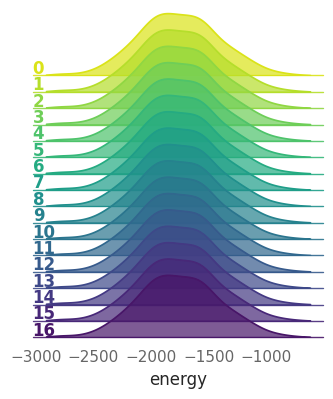

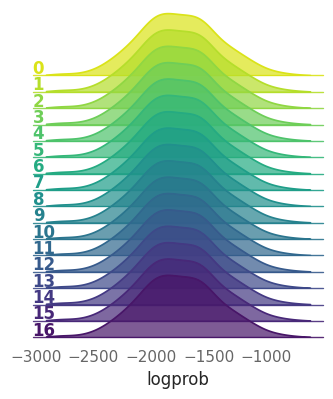

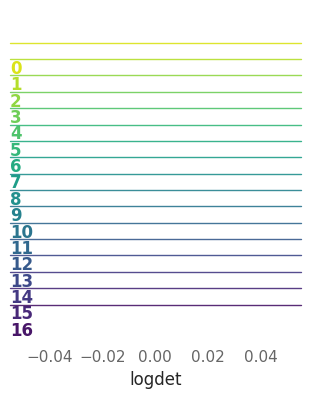

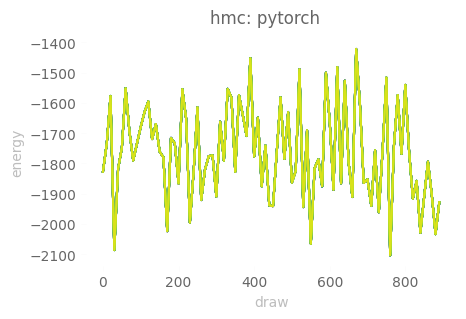

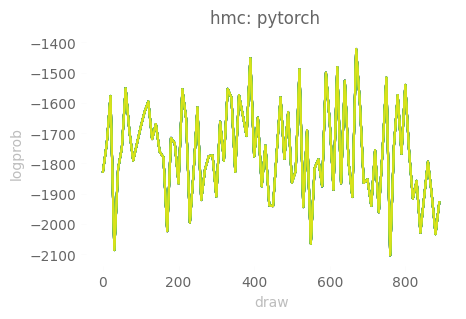

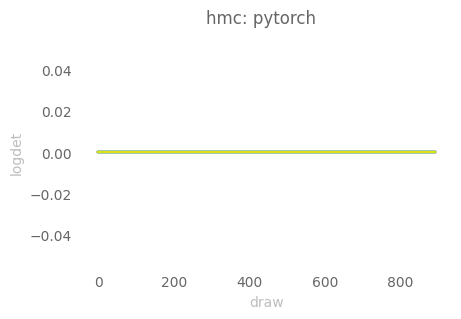

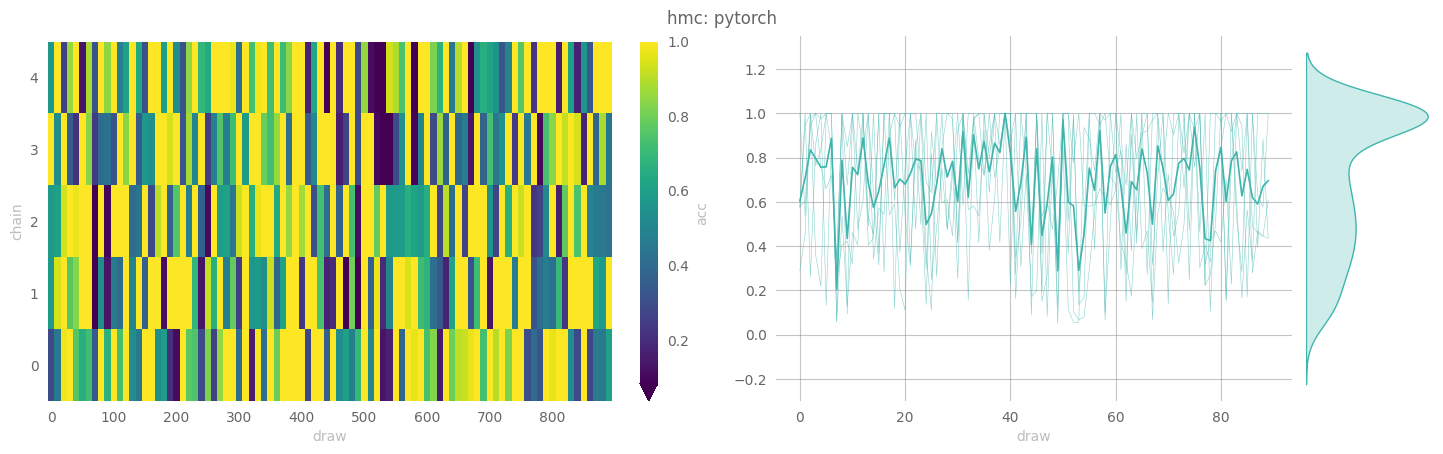

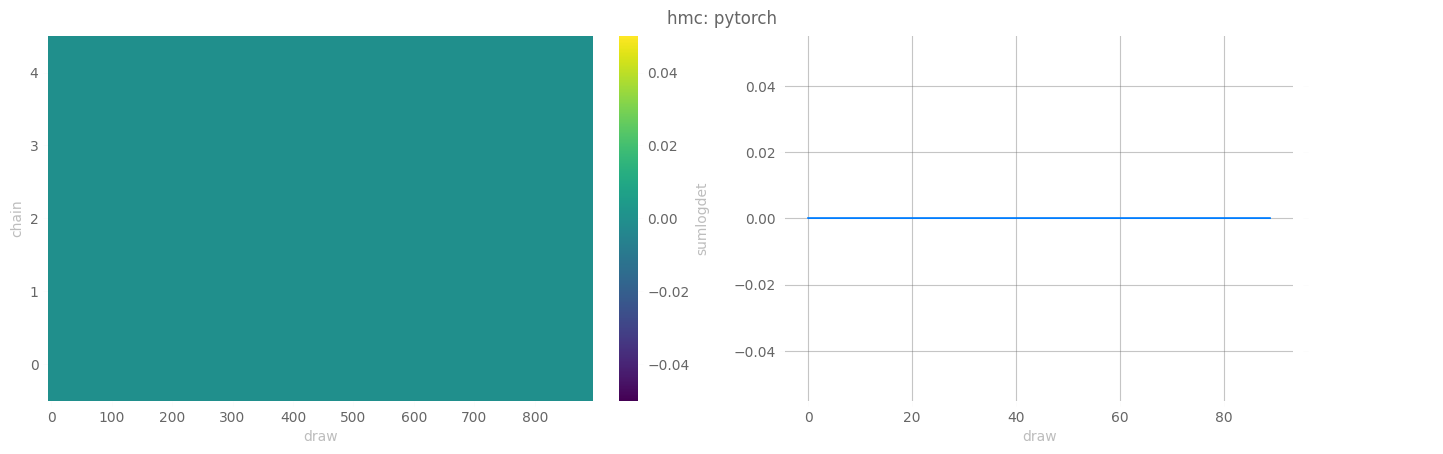

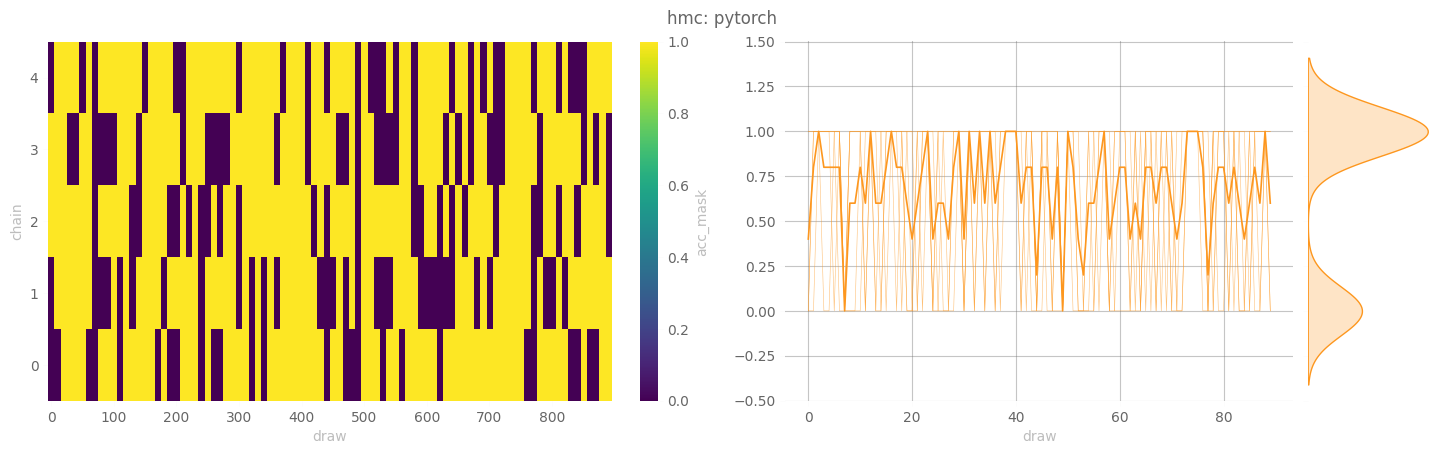

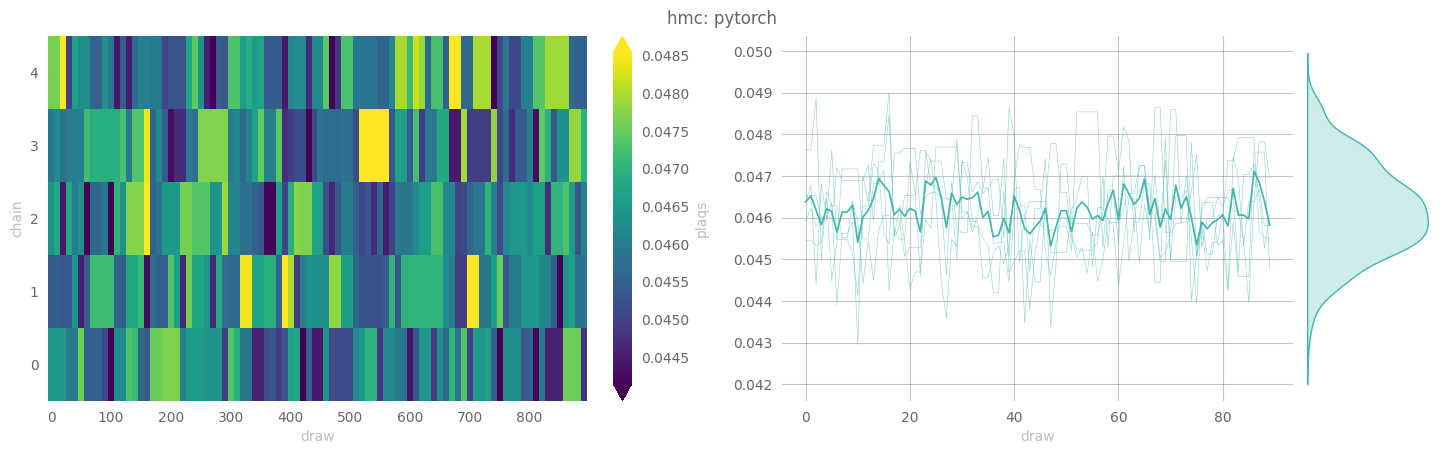

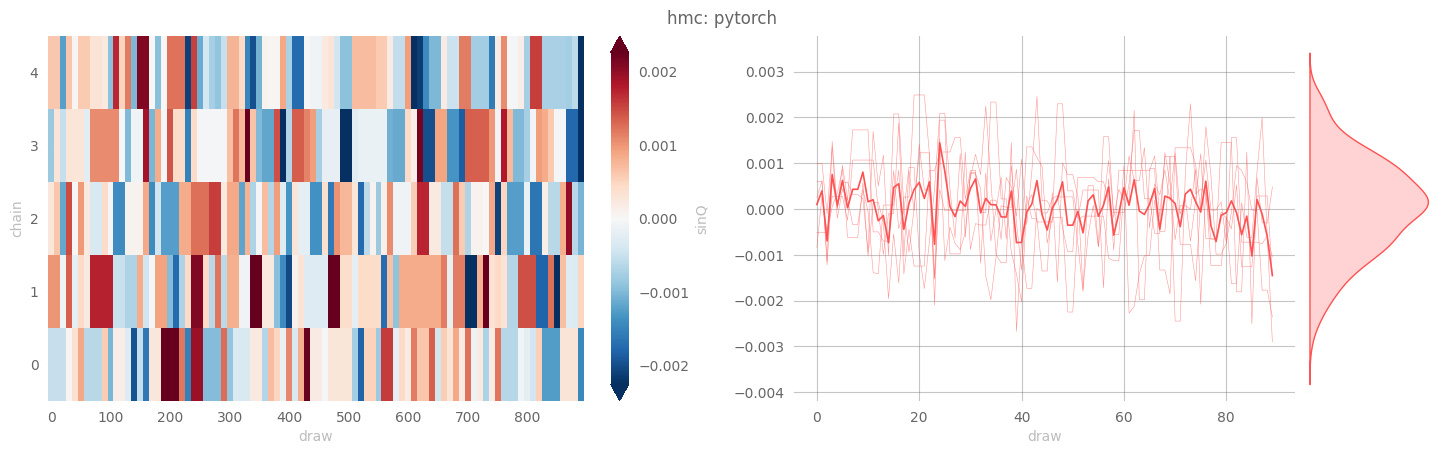

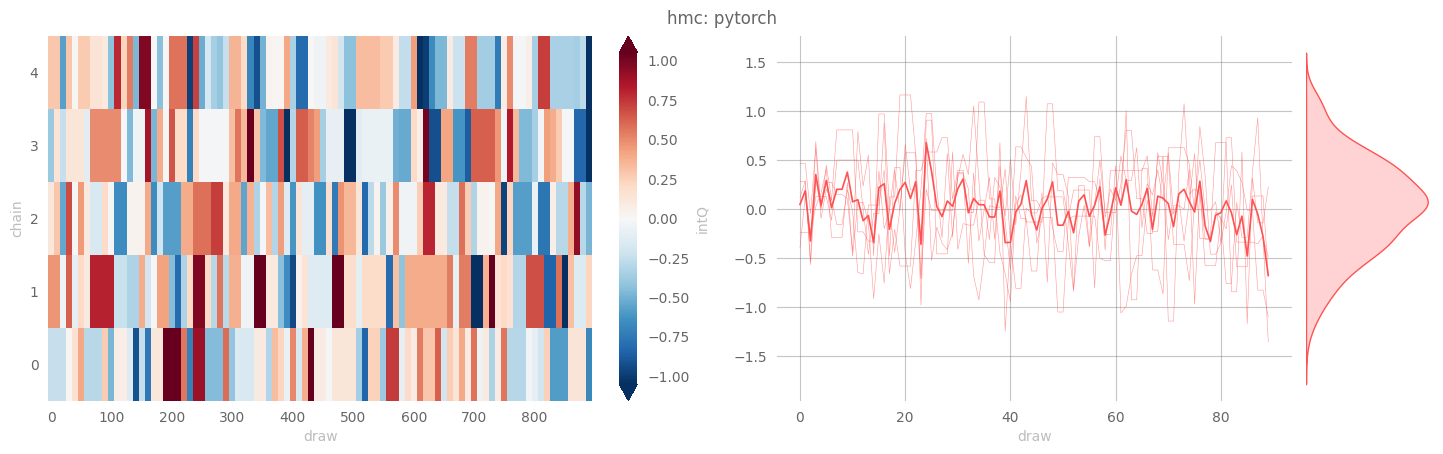

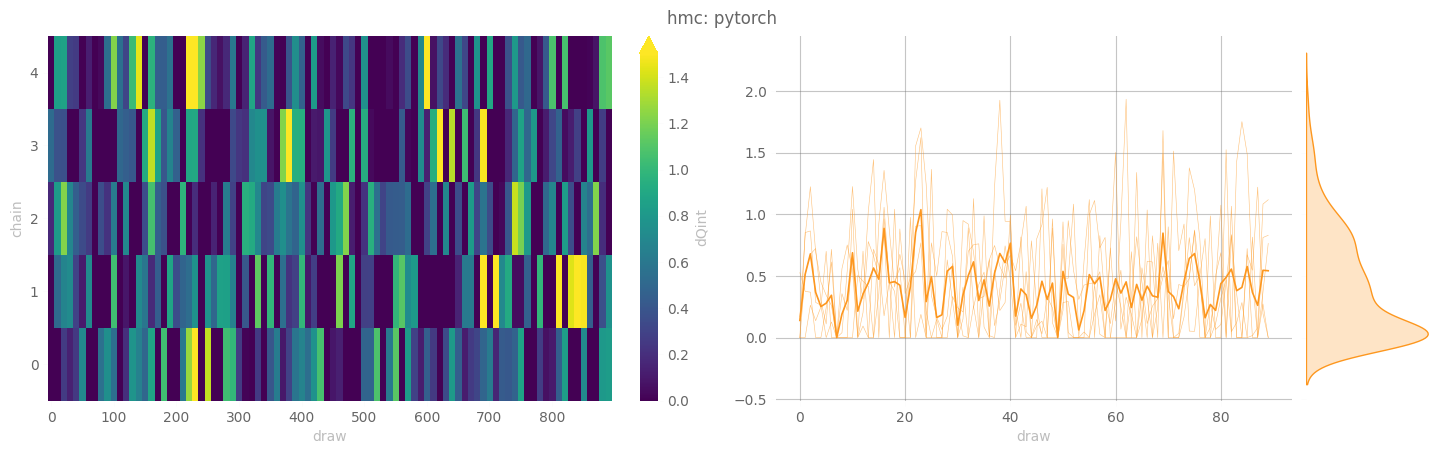

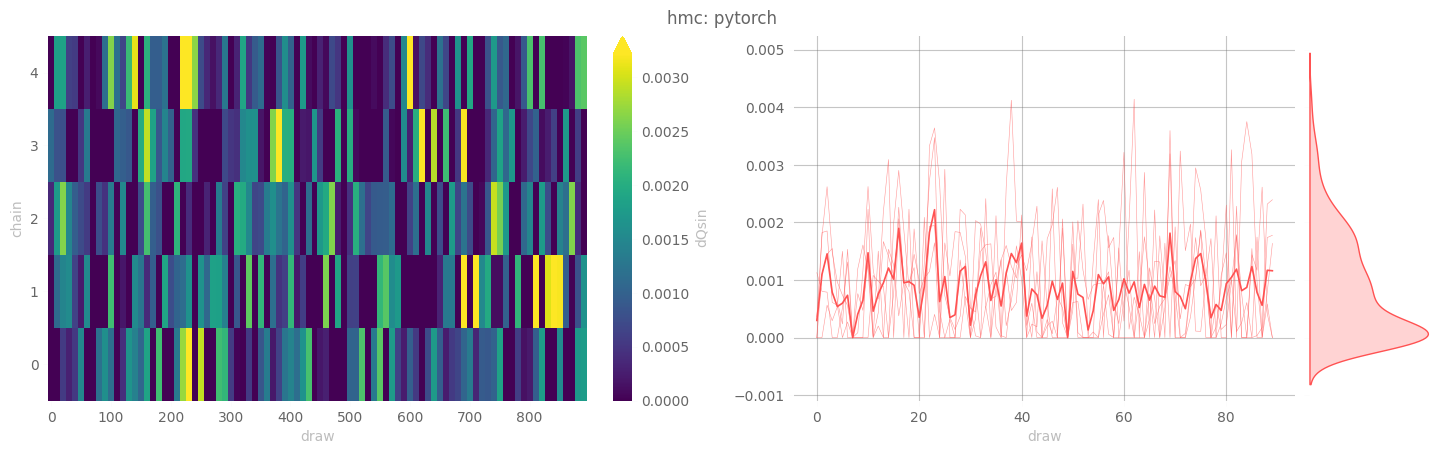

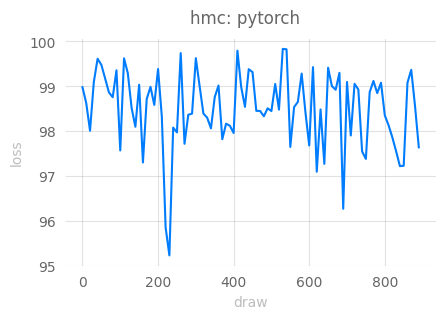

In [13]:
ptExpSU3.trainer.dynamics.eval()

outputs_pt = ptExpSU3.evaluate(
    beta=0.7796,
    eps=0.03125,
    nleapfrog=16,
    eval_steps=100,
    job_type='hmc',
)

In [14]:
dset_pt = ptExpSU3.trainer.histories['hmc'].get_dataset()
dset_tf = tfExpSU3.trainer.histories['hmc'].get_dataset()

In [15]:
dset_pt

<xarray.Dataset>
Dimensions:    (chain: 5, leapfrog: 17, draw: 100)
Coordinates:
  * chain      (chain) int64 0 1 2 3 4
  * leapfrog   (leapfrog) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    energy     (chain, leapfrog, draw) float64 23.52 -1.517e+03 ... -1.693e+03
    logprob    (chain, leapfrog, draw) float64 23.52 -1.517e+03 ... -1.693e+03
    logdet     (chain, leapfrog, draw) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    acc        (chain, draw) float64 1.0 1.0 1.0 0.9238 ... 0.3325 1.0 1.0 1.0
    sumlogdet  (chain, draw) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    acc_mask   (chain, draw) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 1.0 1.0 1.0 1.0
    plaqs      (chain, draw) float64 0.0003055 0.03347 ... 0.04553 0.04549
    sinQ       (chain, draw) float64 0.0005685 -0.0009049 ... -0.002903
    intQ       (chain, draw) float64 0.2654 -0.4225 0.06294 ... -0.273 -1.355
    dQint      (chain, draw) float64 0.6879 0.4854 0.2008 ... 1.082 1.117
    dQsin      (chain, draw) float64 0.001473 0.00104 ... 0.002318 0.002393
    loss       (draw) float64 99.23 98.56 99.68 95.69 ... 99.36 98.56 97.64

In [16]:
dset_tf

<xarray.Dataset>
Dimensions:    (chain: 5, leapfrog: 17, draw: 100)
Coordinates:
  * chain      (chain) int64 0 1 2 3 4
  * leapfrog   (leapfrog) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    energy     (chain, leapfrog, draw) float64 -252.7 -7.263e+04 ... -1.75e+05
    logprob    (chain, leapfrog, draw) float64 -252.7 -7.263e+04 ... -1.75e+05
    logdet     (chain, leapfrog, draw) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    acc        (chain, draw) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 0.2997
    sumlogdet  (chain, draw) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    acc_mask   (chain, draw) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 0.0
    plaqs      (chain, draw) float64 -0.000555 0.2457 0.3432 ... 0.5903 0.5922
    sinQ       (chain, draw) float64 0.001721 -0.0007161 ... -0.0001258
    intQ       (chain, draw) float64 0.8037 -0.3343 0.1581 ... 0.1976 -0.05872
    dQint      (chain, draw) float64 1.138 0.4924 0.06303 ... 0.2589 0.2563 0.0
    dQsin      (chain, draw) float64 0.002437 0.001055 ... 0.0005489 0.0

In [14]:
dset_tf.keys()

KeysView(<xarray.Dataset>
Dimensions:    (draw: 125, chain: 5, leapfrog: 17)
Coordinates:
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123 124
  * chain      (chain) int64 0 1 2 3 4
  * leapfrog   (leapfrog) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
Data variables:
    beta       (draw) float64 6.0 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0
    dQint      (chain, draw) float64 0.219 0.4259 0.2236 ... 0.1631 0.06014
    dQsin      (chain, draw) float64 0.0004691 0.0009123 ... 0.0003493 0.0001288
    energy     (chain, leapfrog, draw) float64 -232.2 -1.019e+05 ... -1.753e+05
    logprob    (chain, leapfrog, draw) float64 -232.2 -1.019e+05 ... -1.753e+05
    logdet     (chain, leapfrog, draw) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    acc        (chain, draw) float64 1.0 1.0 1.0 1.0 ... 0.1975 1.0 1.0 0.8693
    sumlogdet  (chain, draw) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    acc_mask   (chain, draw) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 0.0

In [15]:
dset_pt.keys()

KeysView(<xarray.Dataset>
Dimensions:    (draw: 150, chain: 5, leapfrog: 17)
Coordinates:
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
  * chain      (chain) int64 0 1 2 3 4
  * leapfrog   (leapfrog) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
Data variables:
    loss       (draw) float64 97.68 99.68 99.49 99.78 ... 99.93 99.9 99.97 99.74
    dQint      (chain, draw) float64 0.01376 0.2513 0.1832 ... 0.0 0.0 0.1836
    dQsin      (chain, draw) float64 2.947e-05 0.0005383 ... 0.0 0.0003933
    energy     (chain, leapfrog, draw) float64 -400.7 -1.019e+05 ... -1.751e+05
    logprob    (chain, leapfrog, draw) float64 -400.7 -1.019e+05 ... -1.751e+05
    logdet     (chain, leapfrog, draw) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    acc        (chain, draw) float64 1.0 1.0 1.0 1.0 ... 0.3658 0.01999 1.0
    sumlogdet  (chain, draw) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    acc_mask   (chain, draw) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 0.0

In [16]:
hist_pt = ptExpSU3.trainer.histories['hmc']
hist_tf = tfExpSU3.trainer.histories['hmc']

In [20]:
sorted(hist_pt.history.keys())

['acc',
 'acc_mask',
 'dQint',
 'dQsin',
 'energy',
 'intQ',
 'logdet',
 'logprob',
 'loss',
 'plaqs',
 'sinQ',
 'sumlogdet']

In [21]:
sorted(hist_tf.history.keys())

['acc',
 'acc_mask',
 'beta',
 'dQint',
 'dQsin',
 'energy',
 'intQ',
 'logdet',
 'logprob',
 'plaqs',
 'sinQ',
 'sumlogdet']

In [38]:
print(len(sorted(hist_tf.history.keys())))
print(len(sorted(hist_pt.history.keys())))

12
12


In [22]:
from l2hmc.common import grab_tensor

beta = 6.0
x0pt = ptExpSU3.trainer.lattice.random()
x0tf = tf.constant(grab_tensor(x0pt))

x1pt, metrics_pt = ptExpSU3.trainer.hmc_step((x0pt, beta), eps=0.03125, nleapfrog=16)
x1tf, metrics_tf = tfExpSU3.trainer.hmc_step((x0tf, tf.constant(beta)), eps=0.03125, nleapfrog=16)

In [39]:
metrics_pt.keys()
print(len(metrics_pt.keys()))

12


In [40]:
metrics_tf.keys()
print(len(metrics_tf.keys()))

12


In [26]:
record_pt = {}
record_pt.update(ptExpSU3.trainer.metrics_to_numpy(metrics_pt))

In [27]:
record_tf = {}
record_tf.update(tfExpSU3.trainer.metrics_to_numpy(metrics_tf))

In [41]:
record_pt.keys()
print(len(record_pt.keys()))

12


In [29]:
record_tf.keys()

dict_keys(['energy', 'logprob', 'logdet', 'acc', 'sumlogdet', 'acc_mask', 'plaqs', 'sinQ', 'intQ', 'dQint', 'dQsin', 'loss'])

In [44]:
for key, val in record_pt.items():
    print(f'{key}: {val.shape}')
   

energy: (17, 5)
logprob: (17, 5)
logdet: (17, 5)
acc: (5,)
sumlogdet: (5,)
acc_mask: (5,)
plaqs: (5,)
sinQ: (5,)
intQ: (5,)
dQint: (5,)
dQsin: (5,)
loss: ()


In [45]:
for key, val in hist_tf.history.items():
    print(f'{key}: {np.array(val).shape}')

beta: (125,)
dQint: (125, 5)
dQsin: (125, 5)
energy: (125, 17, 5)
logprob: (125, 17, 5)
logdet: (125, 17, 5)
acc: (125, 5)
sumlogdet: (125, 5)
acc_mask: (125, 5)
plaqs: (125, 5)
sinQ: (125, 5)
intQ: (125, 5)


In [ ]:
from l2hmc.common import clear_cuda_cache
clear_cuda_cache()
outputs_pt_train = ptExpSU3.train(nera=1, nepoch=10)

In [16]:
outputs_tf_train = tfExpSU3.train(nera=1, nepoch=10)

─────────────────────────────────────────────── ERA: 0 / 1, BETA: 6.000 ────────────────────────────────────────────────

InaccessibleTensorError: in user code:

    File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py", line 622, in train_step  *
        xout, metrics = self.dynamics((xinit, beta), training=True)
    File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    InaccessibleTensorError: Exception encountered when calling layer "dynamics" (type Dynamics).
    
    in user code:
    
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 180, in call  *
            return self.apply_transition_fb(inputs, training=training)
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 247, in apply_transition_fb  *
            data = self.generate_proposal_fb(inputs, training=training)
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 419, in generate_proposal_fb  *
            proposed, metrics = self.transition_kernel_fb(init, training=training)
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 562, in transition_kernel_fb  *
            history = self.update_history(
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 453, in get_metrics  *
            energy = self.hamiltonian(state)
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 980, in hamiltonian  *
            potential = self.potential_energy(state.x, state.beta)
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 992, in potential_energy  *
            return self.potential_fn(x=x, beta=beta)
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/lattice/su3/tensorflow/lattice.py", line 278, in action  *
            ps, rs = self._wilson_loops(x, needs_rect=self.c1 != 0)
        File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/lattice/su3/tensorflow/lattice.py", line 199, in _wilson_loops  *
            return tf.stack(plaqs), tf.stack(rects)
    
        InaccessibleTensorError: <tf.Tensor 'dynamics/cond/Trace:0' shape=(5, 8, 8, 8, 16) dtype=complex128> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
        Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.
        
        <tf.Tensor 'dynamics/cond/Trace:0' shape=(5, 8, 8, 8, 16) dtype=complex128> was defined here:
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
              return _run_code(code, main_globals, None,
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/runpy.py", line 87, in _run_code
              exec(code, run_globals)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
              app.launch_new_instance()
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
              app.start()
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
              self.io_loop.start()
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
              self.asyncio_loop.run_forever()
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
              self._run_once()
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
              handle._run()
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/asyncio/events.py", line 81, in _run
              self._context.run(self._callback, *self._args)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
              await self.process_one()
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
              await dispatch(*args)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
              await result
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
              reply_content = await reply_content
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
              res = shell.run_cell(
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
              return super().run_cell(*args, **kwargs)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
              result = self._run_cell(
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
              return runner(coro)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
              coro.send(None)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
              has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
              if await self.run_code(code, result, async_=asy):
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
              exec(code_obj, self.user_global_ns, self.user_ns)
            File "/tmp/ipykernel_1006727/3398474937.py", line 1, in <cell line: 1>
              outputs_tf_train = tfExpSU3.train(nera=1, nepoch=10)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/experiment/tensorflow/experiment.py", line 237, in train
              output = self.trainer.train(
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py", line 843, in train
              x, edata = self.train_epoch(
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py", line 715, in train_epoch
              x, metrics = self.train_step((x, beta))  # type:ignore
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py", line 622, in train_step
              xout, metrics = self.dynamics((xinit, beta), training=True)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
              return fn(*args, **kwargs)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
              return super().__call__(*args, **kwargs)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
              return fn(*args, **kwargs)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
              outputs = call_fn(inputs, *args, **kwargs)
            File "/lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
              return fn(*args, **kwargs)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 179, in call
              if self.config.merge_directions:
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 180, in call
              return self.apply_transition_fb(inputs, training=training)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 247, in apply_transition_fb
              data = self.generate_proposal_fb(inputs, training=training)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 419, in generate_proposal_fb
              proposed, metrics = self.transition_kernel_fb(init, training=training)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 560, in transition_kernel_fb
              if self.config.verbose:
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 562, in transition_kernel_fb
              history = self.update_history(
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 453, in get_metrics
              energy = self.hamiltonian(state)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 980, in hamiltonian
              potential = self.potential_energy(state.x, state.beta)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/tensorflow/dynamics.py", line 992, in potential_energy
              return self.potential_fn(x=x, beta=beta)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/lattice/su3/tensorflow/lattice.py", line 278, in action
              ps, rs = self._wilson_loops(x, needs_rect=self.c1 != 0)
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/lattice/su3/tensorflow/lattice.py", line 165, in _wilson_loops
              for u in range(1, 4):
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/lattice/su3/tensorflow/lattice.py", line 166, in _wilson_loops
              for v in range(0, u):
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/lattice/su3/tensorflow/lattice.py", line 179, in _wilson_loops
              if needs_rect:
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/lattice/su3/tensorflow/lattice.py", line 186, in _wilson_loops
              tr_urul = self.g.trace(
            File "/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/group/su3/tensorflow/group.py", line 69, in trace
              return tf.linalg.trace(x)
        
        The tensor <tf.Tensor 'dynamics/cond/Trace:0' shape=(5, 8, 8, 8, 16) dtype=complex128> cannot be accessed from FuncGraph(name=train_step, id=140120557906144), because it was defined in FuncGraph(name=dynamics_cond_true_217251, id=140120564590672), which is out of scope.
    
    
    Call arguments received by layer "dynamics" (type Dynamics):
      • inputs=('tf.Tensor(shape=(5, 294912), dtype=complex128)', 'tf.Tensor(shape=(), dtype=float64)')
      • training=True
